## Introduction

## NLP and Sentiment Analysis

When you have unstructured data it is useful to categorize it using sentiment analysis. This type of analysis allows you to assign value to texts, sentences and/or headlines. For this project I thought it useful to take financial headlines from news organizations and see if I could reduce the headlines down to a binary product. This means assigning a number to a headline to distinguish it as a negative, positive, or neutral headline; categorizing the sentiment. This is done to be a basis of exploring further headlines and their relations to stock performance. Is it be possible to see how much headlines affect the price of a stock?

#### Dataset:
[Sentiment Analysis for Financial News-Kaggle](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

[Bloomberg Financial Headlines -Scraped](https://rapidapi.com/apidojo/api/bloomberg-market-and-financial-news/endpoints)

## Libraries

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#to see the entire column width:
pd.set_option('display.max_colwidth', -1)

In [103]:
#import and check version of tensorflow
import tensorflow as tf
tf.__version__

'2.3.1'

### Imoport Data

In [104]:
# import and look at data imported from kaggle
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  positive   
1  neutral    
2  neutral    
3  negative   
4  negative   

                                                                                                                                                               Headline  
0  The pretax profit of the group 's life insurance business increased to EUR 36 million from EUR 27 million .                                                           
1  Okhta Center area is expected to have about 700,000 square metres of office premises by 2016 .                                                                        
2  The writing and publication of Lemmink+Æinen - s history is a continuation of earlier collaboration between Antti Tuuri and the company .                            
3  The repurchases shall decrease the distributable capital and reserves .                                                                                               
4  Managing Director 's comments : `` Net sales for the first quarter were notably lower than a year before , especially in Finland , Russia and the Baltic countries .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [105]:
# Look at the instances of each sentiment
df.Sentiment.value_counts()

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

#### Visualize the data

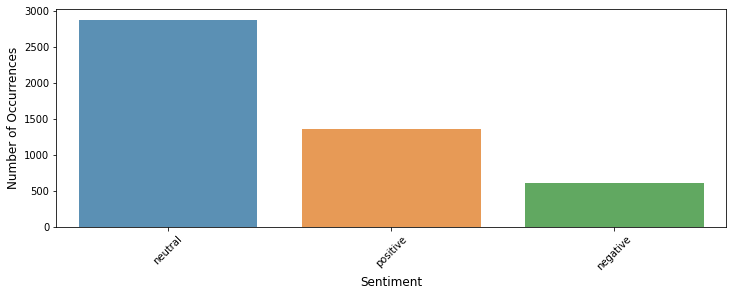

In [106]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

### Clean the Data

In [107]:
# Convert the string in the 'Sentiment' column to numeric form
Sentiment = {'positive': 0, 'neutral': 1, 'negative': 2} 

#df[Sentiment]=df[Sentiment].map(Sentiment)

In [108]:
# traversing through Sentiment column and writing values where key matches
df.Sentiment = [Sentiment[item] for item in df.Sentiment] 
df.head(10)

Sentiment  \
0  0           
1  1           
2  1           
3  2           
4  2           
5  1           
6  2           
7  0           
8  1           
9  0           

                                                                                                                                                                                                                     Headline  
0  The pretax profit of the group 's life insurance business increased to EUR 36 million from EUR 27 million .                                                                                                                 
1  Okhta Center area is expected to have about 700,000 square metres of office premises by 2016 .                                                                                                                              
2  The writing and publication of Lemmink+Æinen - s history is a continuation of earlier collaboration between Antti Tuuri and the company .                                                                                  
3  The repurchases shall decrease the distributable capital and reserves .                                                                                                                                                     
4  Managing Director 's comments : `` Net sales for the first quarter were notably lower than a year before , especially in Finland , Russia and the Baltic countries .                                                        
5  Cencorp would focus on the development , manufacture and marketing of standard products for production automation .                                                                                                         
6  Diluted earnings per share ( EPS ) fell to EUR 0.63 from EUR 1.71 .                                                                                                                                                         
7  Finnish airline Finnair has won a deal with the UK public sector to be the official airline for flights from London Heathrow to Osaka in Japan , as well as flights between Manchester in the UK and Helsinki in Finland .  
8  The contract covers the manufacturing , surface-treatment and installation of the steel structures .                                                                                                                        
9  Operating profit excluding restructuring costs grew to EUR 44.5 million from EUR 31.7 million while operating profit including restructuring costs showed even larger growth to EUR 38.5 million from EUR 7.4 million .

#### Stopwords:
Remove words from strings that have no unique information ('is','an','the).

In [109]:
#nltk.download('stopwords')

stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [110]:
#make a new column for clean headlines and then other columns for different version of data

In [111]:
#check
df.head()

Sentiment  \
0  0           
1  1           
2  1           
3  2           
4  2           

                                                                                                              Headline  
0  pretax profit group life insurance business increased eur 36 million eur 27 million                                  
1  okhta center area expected 700,000 square metres office premises 2016                                                
2  writing publication lemmink+æinen - history continuation earlier collaboration antti tuuri company                  
3  repurchases shall decrease distributable capital reserves                                                            
4  managing director comments `` net sales first quarter notably lower year especially finland russia baltic countries

#### Lemmatization:
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)

In [112]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [113]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline_Lemma'] = df['Headline'].map(lemmatize)

In [114]:
#check
df.head()

Sentiment  \
0  0           
1  1           
2  1           
3  2           
4  2           

                                                                                                              Headline  \
0  pretax profit group life insurance business increased eur 36 million eur 27 million                                   
1  okhta center area expected 700,000 square metres office premises 2016                                                 
2  writing publication lemmink+æinen - history continuation earlier collaboration antti tuuri company                   
3  repurchases shall decrease distributable capital reserves                                                             
4  managing director comments `` net sales first quarter notably lower year especially finland russia baltic countries   

                                                                                                Headline_Lemma  
0  pretax profit group life insurance business increase eur 36 million eur 27 million                           
1  okhta center area expect 700,000 square metre office premise 2016                                            
2  write publication lemmink+æinen - history continuation earlier collaboration antti tuuri company            
3  repurchase shall decrease distributable capital reserve                                                      
4  manage director comment `` net sale first quarter notably low year especially finland russia baltic country

WordCloud to see the commonly used words

In [115]:
#!pip install wordcloud

In [117]:
def wordcloud(dataset):
    '''Wordcloud for the dataset'''
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1000, 
                          height = 600,
                          collocations=False).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds(column='Headline'):
    # Separating out the categories
    pos = df[column][df.Sentiment[df.Sentiment== 1].index]
    neg = df[column][df.Sentiment[df.Sentiment== 0].index]
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    

Positive Sentiment Wordcloud:


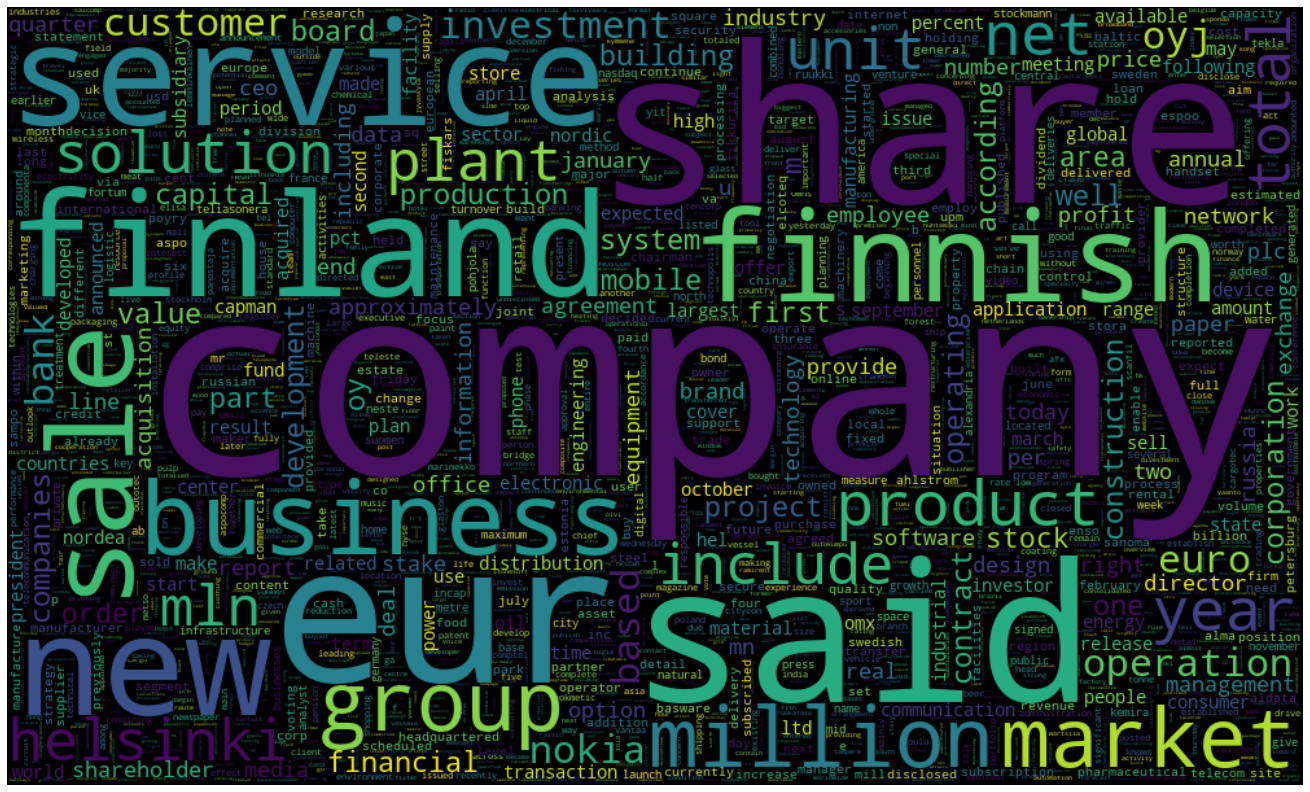

Negative Sentiment Wordcloud:


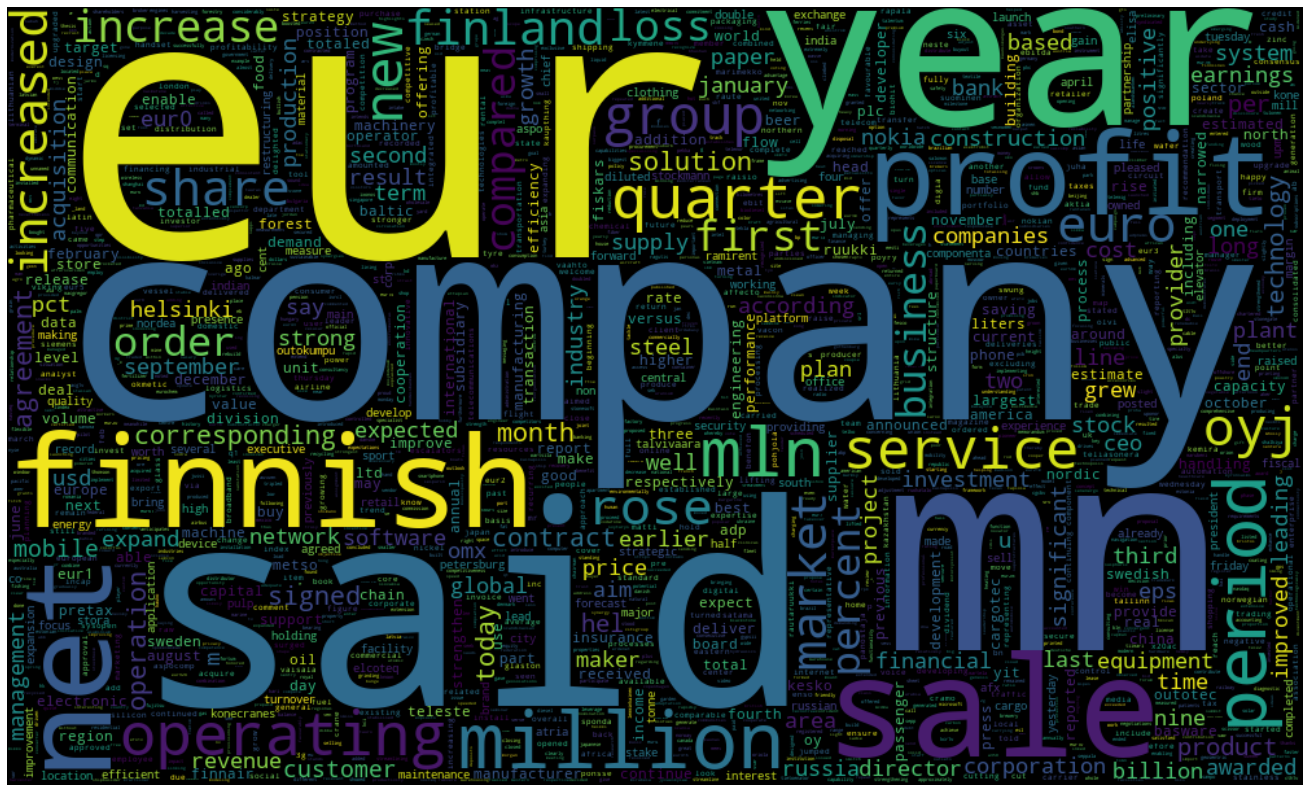

In [118]:
show_wordclouds()

Positive Sentiment Wordcloud:


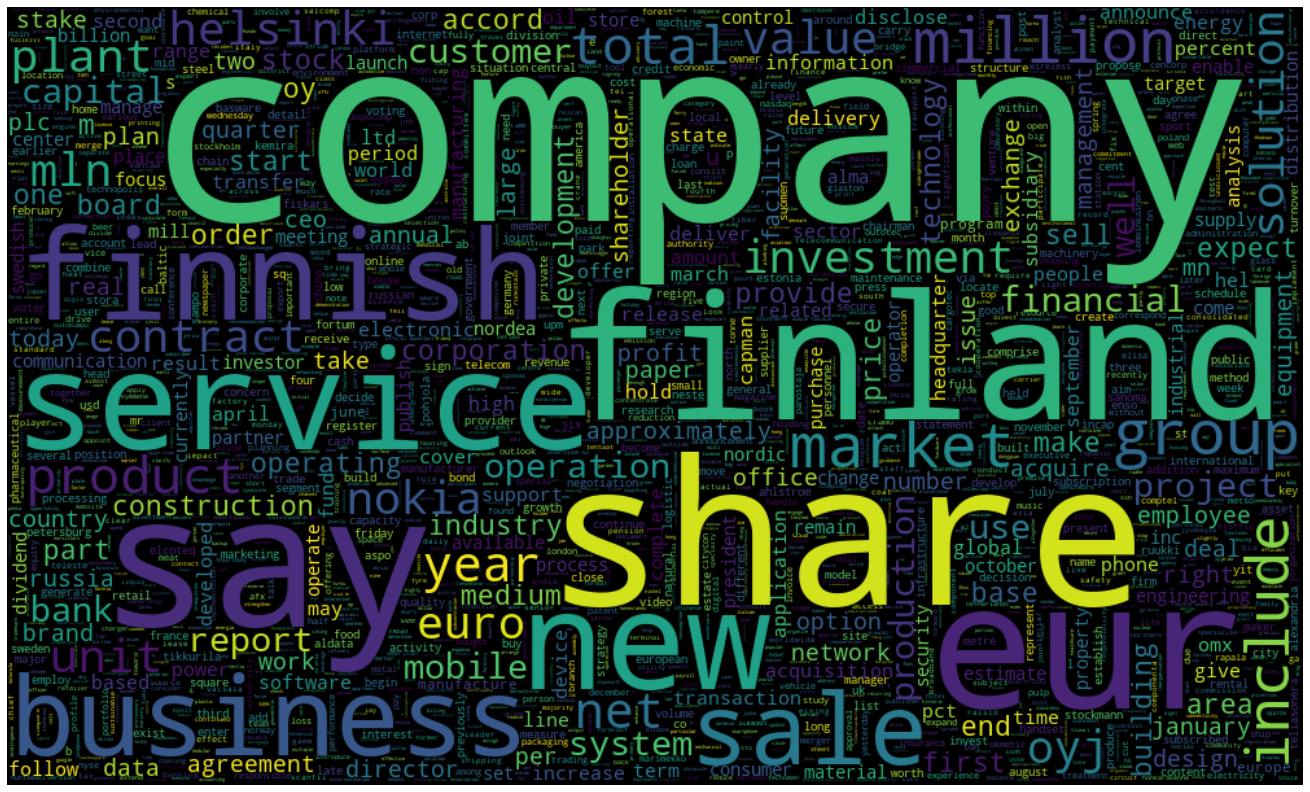

Negative Sentiment Wordcloud:


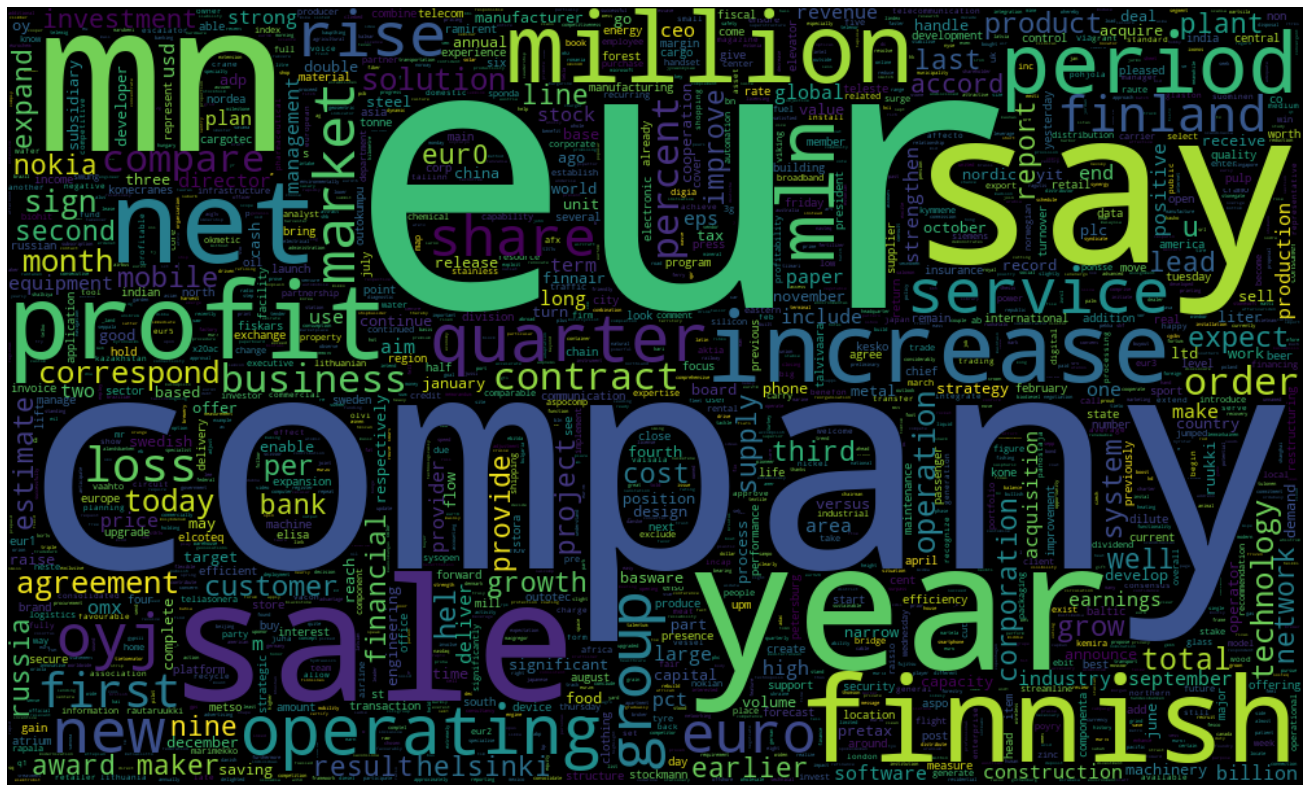

In [119]:
show_wordclouds('Headline_Lemma')

Process the text to convert text to lower-case strip punctuations and symbols etc.

In [120]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


df['Headline_soup'] = df['Headline_Lemma'].apply(cleanText)


In [121]:
df.head()

Sentiment  \
0  0           
1  1           
2  1           
3  2           
4  2           

                                                                                                              Headline  \
0  pretax profit group life insurance business increased eur 36 million eur 27 million                                   
1  okhta center area expected 700,000 square metres office premises 2016                                                 
2  writing publication lemmink+æinen - history continuation earlier collaboration antti tuuri company                   
3  repurchases shall decrease distributable capital reserves                                                             
4  managing director comments `` net sales first quarter notably lower year especially finland russia baltic countries   

                                                                                                Headline_Lemma  \
0  pretax profit group life insurance business increase eur 36 million eur 27 million                            
1  okhta center area expect 700,000 square metre office premise 2016                                             
2  write publication lemmink+æinen - history continuation earlier collaboration antti tuuri company             
3  repurchase shall decrease distributable capital reserve                                                       
4  manage director comment `` net sale first quarter notably low year especially finland russia baltic country   

                                                                                                 Headline_soup  
0  preta profit group life insurance business increase eur 36 million eur 27 million                            
1  okhta center area epect 700,000 square metre office premise 2016                                             
2  write publication lemmink+æinen - history continuation earlier collaboration antti tuuri company            
3  repurchase shall decrease distributable capital reserve                                                      
4  manage director comment `` net sale first quarter notably low year especially finland russia baltic country

#### Counter

In [122]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [123]:
text = df.Headline_Lemma
counter = counter_word(text)

In [124]:
len(counter)

10088

In [125]:
num_words = len(counter)

### Train/Test Split

In [127]:
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(
    df['Headline_soup'], df['Sentiment'], test_size=0.2 , random_state=42)

In [129]:
# Checking on a few of the headlines:
display(training_headlines[:3])
display(training_labels[:3])

432     sale rise 300.9 mln eur compare last year 276.1 mln eur line 299 mln eur consensus figure                         
3071    group - sale period eur 31.6 million eur 36.6 million 1-6/2007 profit ta eur 0.2 1.3 million                     
289     10.58 outokumpu decline 2.74 pct 24.87 eur om helsinki 25 0.55 pct high 2,825.14 om helsinki add 0.64 pct 9,386.89
Name: Headline_soup, dtype: object

432     0
3071    1
289     1
Name: Sentiment, dtype: int64

In [130]:
training_labels.value_counts(normalize=1)

1    0.598297
0    0.278896
2    0.122807
Name: Sentiment, dtype: float64

In [131]:
testing_labels.value_counts(normalize=1)

1    0.577320
0    0.290722
2    0.131959
Name: Sentiment, dtype: float64

### Tokenizer 
Tokenizing involoves splitting sentances and words from the body of the text
The use of a tokenizer creates a number coded to each word thereby allowing 
the neural network to build patterns and learn meaning.

In [132]:
# function to tokenize text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [134]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training_headlines)
X_train = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(X_train)
print('Found %s unique tokens.' % len(training_padded))


Found 3876 unique tokens.


In [135]:
# check the shape of data tensor:
X_test = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(X_test, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded.shape)

Shape of data tensor: (970, 50)


In [136]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [139]:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', training_headlines[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   32  577  155   72    1 1534    1  196   16    4  630  386   24]

The actual headline:
 repurchase shall decrease distributable capital reserve

Label:
 2


In [141]:
from tensorflow.keras.utils import to_categorical
training_labels_ohe = to_categorical(training_labels)
testing_labels_ohe = to_categorical(testing_labels)

testing_labels_ohe[0]

array([0., 1., 0.], dtype=float32)

In [142]:
testing_labels_ohe.shape

(970, 3)

### Functions for Model Evaluation:

In [146]:
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
    
def visualize_training_results(results):
    """
   1 Input: The Training and 
    Validation/Testing Dictionary 
    of Loss and Accuracy
    
    Output: 2 Plots of Loss vs. Epochs
    and Accuracy vs. Epochs
    """
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['Validation Loss', 'Training Loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['Validation Accuracy', 'Training Accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

### Model 1 (LSTM):

In [149]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [150]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1008800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 1,053,219
Trainable params: 1,053,219
Non-trainable params: 0
_________________________________________________________________


In [151]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 24,
                    #validation_data=(testing_padded, testing_labels_ohe), 
                    validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
146/146 [==============================] - 7s 46ms/step - loss: 0.8707 - accuracy: 0.6115 - val_loss: 0.7143 - val_accuracy: 0.7139
Epoch 2/50
146/146 [==============================] - 6s 41ms/step - loss: 0.5316 - accuracy: 0.7795 - val_loss: 0.6835 - val_accuracy: 0.7088
Epoch 3/50
146/146 [==============================] - 6s 42ms/step - loss: 0.2393 - accuracy: 0.9157 - val_loss: 0.7224 - val_accuracy: 0.7242
Epoch 4/50
146/146 [==============================] - 7s 48ms/step - loss: 0.1222 - accuracy: 0.9604 - val_loss: 0.8793 - val_accuracy: 0.7345
Epoch 5/50
146/146 [==============================] - 7s 46ms/step - loss: 0.0647 - accuracy: 0.9805 - val_loss: 1.1485 - val_accuracy: 0.7139
Epoch 6/50
146/146 [==============================] - 6s 40ms/step - loss: 0.0525 - accuracy: 0.9848 - val_loss: 1.2035 - val_accuracy: 0.7268
Epoch 7/50
146/146 [==============================] - 6s 41ms/step - loss: 0.0411 - accuracy: 0.9871 - val_loss: 1.2583 - val_accuracy: 0.7165

In [153]:
y_hat = model.predict(testing_padded)
predicted = y_hat.argmax(axis=1)
true = testing_labels_ohe.argmax(axis=1)

In [154]:
import sklearn.metrics as metrics

print(metrics.classification_report(true,predicted))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       282
           1       0.77      0.80      0.79       560
           2       0.78      0.48      0.60       128

    accuracy                           0.72       970
   macro avg       0.72      0.65      0.67       970
weighted avg       0.72      0.72      0.71       970



While the precision, recall and f1 score are greater than 50% I believe they can be increased by addressing a class imbalanced. This is evident with the 80% score given to the neutral (1) rating which has a far greater amount of data compared to the others.

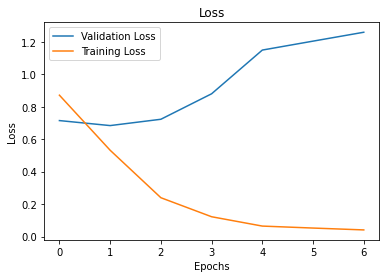

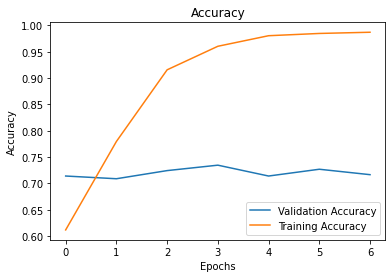

In [155]:
visualize_training_results(history)
#model_eval(history)

The graphs show over-fitting of our data

## Model 2

In [156]:
embedding_dim = 100

model2 = Sequential()
model2.add(Embedding(num_words, embedding_dim, input_length=max_length))
model2.add(LSTM(64, dropout = 0.1))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [157]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model2.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 32,
                    #validation_data=(testing_padded, testing_labels_ohe), 
                    validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
109/109 [==============================] - 5s 44ms/step - loss: 0.8871 - accuracy: 0.6101 - val_loss: 0.7063 - val_accuracy: 0.7010
Epoch 2/50
109/109 [==============================] - 4s 38ms/step - loss: 0.6300 - accuracy: 0.7317 - val_loss: 0.6981 - val_accuracy: 0.7268
Epoch 3/50
109/109 [==============================] - 4s 40ms/step - loss: 0.3516 - accuracy: 0.8707 - val_loss: 0.7140 - val_accuracy: 0.7345
Epoch 4/50
109/109 [==============================] - 4s 41ms/step - loss: 0.1798 - accuracy: 0.9424 - val_loss: 0.8690 - val_accuracy: 0.7191
Epoch 5/50
109/109 [==============================] - 4s 39ms/step - loss: 0.1119 - accuracy: 0.9685 - val_loss: 1.1068 - val_accuracy: 0.7113
Epoch 6/50
109/109 [==============================] - 4s 39ms/step - loss: 0.0846 - accuracy: 0.9774 - val_loss: 1.2337 - val_accuracy: 0.7088
Epoch 7/50
109/109 [==============================] - 4s 38ms/step - loss: 0.0623 - accuracy: 0.9831 - val_loss: 1.2825 - val_accuracy: 0.7216

This new model did not result in a notable difference from the previous model.

In [159]:
y_hat = model2.predict(testing_padded)
predicted = y_hat.argmax(axis=1)
true = testing_labels_ohe.argmax(axis=1)

In [160]:
print(metrics.classification_report(true,predicted))

              precision    recall  f1-score   support

           0       0.64      0.56      0.60       282
           1       0.77      0.84      0.80       560
           2       0.63      0.56      0.59       128

    accuracy                           0.72       970
   macro avg       0.68      0.65      0.66       970
weighted avg       0.71      0.72      0.72       970



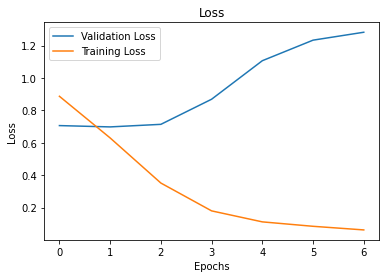

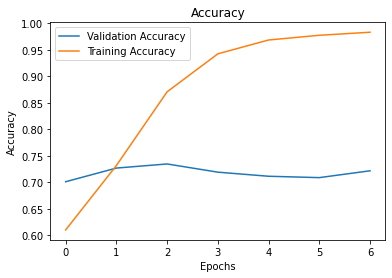

In [161]:
#model_eval(history) #seperate val and loss
visualize_training_results(history)

### Import Headlines To Test Model

import requests

url = "https://bloomberg-market-and-financial-news.p.rapidapi.com/news/list-by-region"

querystring = {"id":"home-v3"}

headers = {
    'x-rapidapi-key': "",
    'x-rapidapi-host': "bloomberg-market-and-financial-news.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

In [233]:
# import requests

# url = "https://bloomberg-market-and-financial-news.p.rapidapi.com/news/list-by-region"

# querystring = {"id":"home-v3"}

# headers = {
#     'x-rapidapi-key': "hidden",
#     'x-rapidapi-host': "bloomberg-market-and-financial-news.p.rapidapi.com"
#     }

# response = requests.request("GET", url, headers=headers, params=querystring)

# print(response.text)

In [163]:
# response.json()

In [164]:
# results = response.json()
# results.keys()

In [165]:

# modules = results['modules']
# len(modules)

Loops to get more stories

In [166]:
# titles = []
# dates = []
# for module in modules:
#     for story in module['stories']:
#         titles.append(story['title'])
#         dates.append(story['id'])

In [167]:
# results_df = pd.DataFrame({'id': dates, 'titles': titles})
# results_df

In [168]:
#results_df.to_csv('bloomberg_news.csv', index=False)

In [169]:
pd.read_csv('bloomberg_news.csv')

id  \
0   2021-02-17/texas-crisis-deepens-economic-fallout-spreads-energy-update                
1   2021-02-17/covid-19-vaccination-tracker-charting-u-s-rates-by-race-demographics       
2   2021-02-17/at-93-she-waged-war-on-jpmorgan-and-two-financial-advisors-her-grandsons   
3   2021-02-17/revlon-debacle-could-turn-citi-into-big-distressed-debt-investor           
4   2021-02-17/for-griffin-s-return-to-washington-citadel-is-a-bigger-target              
..                                                                       ...              
74  2021-02-15/daimler-steps-up-profit-push-after-breakup-plan-boosts-shares              
75  2021-02-17/schumer-warren-challenge-biden-on-student-debt-cancellation                
76  2021-02-17/citi-can-t-have-its-900-million-back                                       
77  2021-02-17/u-s-economy-surges-into-2021-as-sales-output-top-forecasts                 
78  2021-02-17/stimulus-fueled-spending-in-january-bodes-well-for-retail-economy          

                                                                               titles  
0   Texas Crisis Deepens, Economic Fallout Spreads: Energy Update                      
1   U.S. Vaccine Data Reveal Big Racial Gaps in Who’s Getting Shots: Covid-19 Tracker  
2   At 93, She Waged War on JPMorgan—and Her Own Grandsons                             
3   Citi May Get Stuck With Huge Chunk of Distressed Revlon Debt                       
4   For Griffin’s Return to Washington, Citadel Is a ‘Bigger Target’                   
..                                                               ...                   
74  Daimler Steps Up Profit Push After Breakup Plan Boosts Shares                      
75  Schumer, Warren Challenge Biden on Student Debt Cancellation                       
76  Citi Can’t Have Its $900 Million Back                                              
77  U.S. Economy Surges Into 2021 as Sales, Output Top Forecasts                       
78  Have Stimulus, Will Spend                                                          

[79 rows x 2 columns]

In [170]:
df_bloom = pd.read_csv('bloomberg_news.csv')

In [171]:
print("Shape:", df_bloom.shape, "\n\n")
print(df_bloom.info())

Shape: (79, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      79 non-null     object
 1   titles  79 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB
None


In [172]:
#module.keys()

In [173]:
#len(module['stories'])

In [174]:
# story = module['stories'][0]
# story

In [175]:
#story['title']

### Prepare Bloomberg Headlines for Modeling

In [212]:
#importing the scraped data 
df_scrape = pd.read_csv('BloombergSentAnalysis.csv', 
                        names = ['ScrapedSentiment', 'Title'],
                        encoding='latin-1')

#df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 #encoding='latin-1')
df_scrape = df_scrape.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df_scrape.head())
print("Shape:", df_scrape.shape, "\n\n")
print(df_scrape.info())

ScrapedSentiment  \
0  2                  
1  0                  
2  1                  
3  1                  
4  1                  

                                                               Title  
0  British Entrepreneur Tobin Plans Amsterdam Tech SPAC               
1  Unity Fading Away as Republicans Blast Biden Stimulus Plan         
2  Powell Urges âSociety-Wideâ Push to Deliver Full Employment    
3  Public Displays of Affection for Urban Life                        
4  PayPalâs Bid for Growth, Crypto Moves Are Focus of Investor Day

Shape: (51, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ScrapedSentiment  51 non-null     int64 
 1   Title             51 non-null     object
dtypes: int64(1), object(1)
memory usage: 944.0+ bytes
None


In [214]:
# Look at the instances of each sentiment
df_scrape.ScrapedSentiment.value_counts()

2    19
1    16
0    16
Name: ScrapedSentiment, dtype: int64

In [216]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


df_scrape['Title_Soup'] = df_scrape['Title'].apply(cleanText)


In [217]:
df_scrape.head()

ScrapedSentiment  \
0  2                  
1  0                  
2  1                  
3  1                  
4  1                  

                                                               Title  \
0  British Entrepreneur Tobin Plans Amsterdam Tech SPAC                
1  Unity Fading Away as Republicans Blast Biden Stimulus Plan          
2  Powell Urges âSociety-Wideâ Push to Deliver Full Employment     
3  Public Displays of Affection for Urban Life                         
4  PayPalâs Bid for Growth, Crypto Moves Are Focus of Investor Day   

                                                          Title_Soup  
0  british entrepreneur tobin plans amsterdam tech spac               
1  unity fading away as republicans blast biden stimulus plan         
2  powell urges âsociety-wideâ push to deliver full employment    
3  public displays of affection for urban life                        
4  paypalâs bid for growth, crypto moves are focus of investor day

In [218]:
stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df_scrape['TitleSW'] = df_scrape['Title'].map(remove_stopwords)
df_scrape.head()

ScrapedSentiment  \
0  2                  
1  0                  
2  1                  
3  1                  
4  1                  

                                                               Title  \
0  British Entrepreneur Tobin Plans Amsterdam Tech SPAC                
1  Unity Fading Away as Republicans Blast Biden Stimulus Plan          
2  Powell Urges âSociety-Wideâ Push to Deliver Full Employment     
3  Public Displays of Affection for Urban Life                         
4  PayPalâs Bid for Growth, Crypto Moves Are Focus of Investor Day   

                                                          Title_Soup  \
0  british entrepreneur tobin plans amsterdam tech spac                
1  unity fading away as republicans blast biden stimulus plan          
2  powell urges âsociety-wideâ push to deliver full employment     
3  public displays of affection for urban life                         
4  paypalâs bid for growth, crypto moves are focus of investor day   

                                                        TitleSW  
0  british entrepreneur tobin plans amsterdam tech spac          
1  unity fading away republicans blast biden stimulus plan       
2  powell urges âsociety-wideâ push deliver full employment  
3  public displays affection urban life                          
4  paypalâs bid growth, crypto moves focus investor day

#### Train/Test Split

In [221]:
training_title, testing_title, training_labels_new, testing_labels_new = train_test_split(
    df_scrape['TitleSW'], df_scrape['ScrapedSentiment'], test_size=0.2 , random_state=42)

#### Tokenize 

In [222]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training_title)
X_new = tokenizer.texts_to_sequences(training_title)
training_padded_new = pad_sequences(X_new)
print('Found %s unique tokens.' % len(training_padded_new))


Found 40 unique tokens.


In [224]:
X_test_new = tokenizer.texts_to_sequences(testing_title)
testing_padded_new = pad_sequences(X_test_new, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded_new.shape)

Shape of data tensor: (11, 50)


In [225]:
# Encode the new sentiment column with ohe

training_labels_ohe_new = to_categorical(training_labels_new)
testing_labels_ohe_new = to_categorical(testing_labels_new)

testing_labels_ohe_new[0]

array([0., 0., 1.], dtype=float32)

### Apply Model2 to New Scraped Data

In [236]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history_new = model2.fit(training_padded_new, training_labels_ohe_new, 
                    epochs=num_epochs,
                    batch_size = 32,
                    #validation_data=(testing_padded, testing_labels_ohe), 
                    validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
2/2 [==============================] - 0s 32ms/step - loss: 0.1371 - accuracy: 0.9722 - val_loss: 1.8926 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 18ms/step - loss: 0.0870 - accuracy: 0.9722 - val_loss: 1.9204 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 23ms/step - loss: 0.1098 - accuracy: 0.9444 - val_loss: 1.9477 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 0s 18ms/step - loss: 0.0753 - accuracy: 0.9722 - val_loss: 1.9725 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 0s 19ms/step - loss: 0.0844 - accuracy: 0.9722 - val_loss: 1.9934 - val_accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 0s 16ms/step - loss: 0.0803 - accuracy: 0.9722 - val_loss: 2.0084 - val_accuracy: 0.0000e+00
Epoch 00006: early stopping


In [238]:
y_hat_new = model2.predict(testing_padded_new)
predicted_new = y_hat_new.argmax(axis=1)
true_new = testing_labels_ohe_new.argmax(axis=1)

In [240]:
print(metrics.classification_report(true_new,predicted_new))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.27      1.00      0.43         3

    accuracy                           0.27        11
   macro avg       0.09      0.33      0.14        11
weighted avg       0.07      0.27      0.12        11



## Summary

This was an interesting challenge. It is fascinating that a computer model can read human language and is able to assign a sentiment to it. An example would be reading amazon reviews and classifying them for research purposes. While this model needs work to make it more accurate, it is possible to have the machine become more accurate in its reading. This type of artificial intelligence helps to connect man and machine even more naturally. As voice recognition software becomes more common so will the application of natural language processing. I look forward to seeing the possibilities.

#### Actionable Recommendations

1. To increase accuracy it is notable to address the class imbalance of our sentiment value set.  The neutral ratings had a higher accuracy (80%) due to the greater amount of data.
2. Sentiment analysis can be used to cross reference stock prices. This could help predict the valuation of a stock that day based on a headline released at or before trading begins.
3. LSTM modeling is useful but adding more neural depth can help accuracy. It is noteworthy to try and model headlines using different methods of cleaning such as Beautiful_Soup or Lemminazation.